In [1]:
#coding utf8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import tensorflow as tf
import keras_tuner as kt
from scipy.io import loadmat
from tensorflow import keras
from tensorflow.keras import layers, metrics
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import svm
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.feature_selection import mutual_info_regression, f_regression, r_regression
import sklearn
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
#from PyIF import te_compute as te
#from neuralprophet import NeuralProphet

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
'''
Functions for loading in and combining data
'''

def load_df(file_name, sheet = 'Sheet 1'):
    '''
    Load a file into a data frame that is quarterly from the Eurostat website
    '''
    df = pd.read_excel(file_name, sheet_name=sheet)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df.replace(':', np.nan, inplace=True)
    df.index = df.iloc[:, 0]
    df.drop(df.columns[[0]], axis=1, inplace=True)
    for i in df.columns[:]:
        df[i] = df[i].apply(pd.to_numeric, errors="coerce")
    df.interpolate(method='linear', inplace=True, axis = 1)
    df.sort_index(inplace=True)
    df = df.rename({'Germany (until 1990 former territory of the FRG)': 'Germany'})
    return df

def create_per_employeer(GDP_df, HW_df, employees_df):
    ''' 
    Inputs: GDP, hours worked, and employees dataframes
    Output: dataframe with per-employee GDP and per hour worked GDP
    '''
    cols =(list(set(GDP_df.columns) and set(employees_df.columns) and set(HW_df.columns)))
    cols.sort()
    idx = cols.pop()
    per_employee_df = pd.DataFrame(index=GDP_df.index, columns=cols)
    per_HW_df = pd.DataFrame(index=GDP_df.index, columns=cols)
    for i in cols:
        per_employee_df[i] = GDP_df[i]/employees_df[i]
        per_HW_df[i] = per_employee_df[i]/HW_df[i]
    return per_employee_df, per_HW_df

def country_code_to_name(df):
    '''
    Renames country codes to country names
    '''
    df = df.rename({'AUT': 'Austria', 'BEL': 'Belgium', 'DEU': 'Germany','EST': 'Estonia','FIN': 'Finland','ESP': 'Spain','FRA': 'France','GRC': 'Greece','IRL': 'Ireland','ITA': 'Italy','LTU': 'Lithuania','LUX': 'Luxembourg','LVA': 'Latvia','PRT': 'Portugal','NLD': 'Netherlands','SVK': 'Slovakia','SVN': 'Slovenia','ISL': 'Iceland','GBR': 'United Kingdom','CHE': 'Switzerland','CZE': 'Cezch Republic','DNK': 'Denmark','HUN': 'Hungary','NOR': 'Norway','POL': 'Poland','SWE': 'Sweden'})
    return df

def yearly_to_quarterly(df):
    '''
    Inputs: df
    Converts the data from yearly to quarterly
    Outputs: quarterly_df
    '''
    data = df.to_numpy(dtype=np.float64)
    data = np.repeat(data, 4, axis = 1)
    quarterly_df = pd.DataFrame(data)
    quarterly_df.index = df.index
    quarterly_df.columns = GDP_df.columns[(int(df.columns[0]) - 1975)*4:(int(df.columns[-1]) - 2021)*4]
    return quarterly_df

def match_df(dfs):
    ''' 
    Input : dataframes
    This function matches dataframes by their index and column 
    Output: matched dataframes
    '''
    idx = set(dfs[0].index)
    cols = set(dfs[0].columns)
    for i in dfs:
        idx = idx.intersection(set(i.index))
        cols = cols.intersection(set(i.columns))
    cols = list(cols)
    idx = list(idx)
    cols.sort()
    idx.sort()
    for i in range(len(dfs)):
        dfs[i] = dfs[i].loc[idx]
        dfs[i] = dfs[i][cols]
    return dfs

def to_datetime(df):
    df.columns = [w.replace('-Q1','-01') for w in df.columns]
    df.columns = [w.replace('-Q2','-04') for w in df.columns]
    df.columns = [w.replace('-Q3', '-07') for w in df.columns]
    df.columns = [w.replace('-Q4', '-10') for w in df.columns]
    for i in df.columns[:]:
        i = np.datetime64(i)
    df.columns = pd.to_datetime(df.columns)
    return df

def extend_df(dfs):
    idx = set(dfs[0].index)
    cols = set(dfs[0].columns)
    for i in dfs:
        idx = idx.union(set(i.index))
        cols = cols.union(set(i.columns))
    cols = list(cols)
    idx = list(idx)
    cols.sort()
    idx.sort()
    for i in range(len(dfs)):
        dfs[i] = dfs[i].reindex(index=idx, columns=cols)
        dfs[i] = dfs[i].loc[idx]
        dfs[i] = dfs[i][cols]
        dfs[i] = to_datetime(dfs[i])
        dfs[i].interpolate(method='polynomial', order = 5, inplace = True, limit = 100, limit_direction = 'both', axis = 1)
        dfs[i].fillna(0)
    return dfs


'''
Functions for RNN time series prediction
'''

def process_data(X, y, split_point, time_step, data_memory):
    '''
    Inputs: X, y, split_point, time_step, data_memory
    Splits data into training and testing data
    Outputs: X_train, X_test, y_train, y_test
    '''
    X_norm, X_attrs, y_norm, y_attrs = normalise(X, y)
    split_point = int(X_norm.shape[0] *split_point)
    y_norm = np.roll(y_norm, -time_step)
    nrows = X_norm.shape[0]
    samples = X_norm.shape[1]
    X_norm = np.repeat(X_norm, data_memory, 0).reshape(nrows, data_memory, samples)
    x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, split_point)
    return x_train, x_test, y_train, y_test, nrows, samples, X_norm, y_norm, X_attrs, y_attrs

def normalise(X, y):
    '''
    Inputs: X, y
    Normalises the data by subtracting the mean and dividing by the standard deviation
    Outputs : X_norm, y_norm, X_attrs, y_attrs
    '''
    X_attrs = np.zeros((X.shape[-1], 2))
    y_attrs = np.zeros((y.shape[-1], 2))
    X_norm = np.zeros(X.shape)
    y_norm = np.zeros(y.shape)
    for i in range(X.shape[-1]):
        X_attrs[i, :] = [np.mean(X[:, i]), np.var(X[:, i])]
        X_norm[:, i] = (X[:, i] - np.mean(X[:, i]))/np.var(X[:, i])**0.5
    for i in range(y.shape[-1]):
        y_attrs[i, :] = [np.mean(y[:, i]), np.var(y[:, i])]
        y_norm[:, i] = (y[:, i] - np.mean(y[:, i]))/np.var(y[:, i])**0.5 
    return X_norm, X_attrs, y_norm, y_attrs

def train_test_split(X, y, split_point):
    '''
    Splits the data into training and testing data
    '''
    x_train = X[:split_point, :, :]
    x_test = X[split_point:, :, :]
    y_train = y[:split_point]
    y_test = y[split_point:]
    return x_train, x_test, y_train, y_test
        
def create_model(layers, input_shape, print_summary):
    '''
    Creates a model with the specified layers
    '''
    model = keras.Sequential(layers)
    model.build(input_shape=input_shape)
    model.compile(loss='mse', optimizer='adam', metrics = [tf.keras.metrics.MeanSquaredError()])
    if print_summary:
        model.summary()
    return model

def run_model(X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point):
    '''
    Inputs: X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point
    Runs the model on the data
    Outputs: model, history
    '''
    x_train, x_test, y_train, y_test, nrows, samples, X_norm, y_norm, X_attrs, y_attrs = process_data(X, y, split_point, time_step, data_memory)
    input_shape = (x_train.shape[0], data_memory, samples)
    model = create_model(model_layer, input_shape, print_summary)
    history = model.fit(x_train, y_train, validation_split = 0.1, epochs= epochs , batch_size=batch_size)
    y_pred_norm = np.concatenate((model.predict(x_train[:, :, :]), model.predict(x_test[:, :, :])))
    y_pred_norm = np.roll(y_pred_norm, 1, axis = 1)
    y_pred = y_pred_norm *y_attrs[:, 1]**0.5 + y_attrs[:, 0]
    return y_pred, history

'''
Regression stuff
'''

def run_regr(X, y, t, regr, colours):
    regr.fit(X, y)
    nrows = X.shape[0]
    y_reg = np.zeros(nrows)  
    for i in range(nrows):
        y_reg[i] = regr.predict(np.array([X[i, :]]))
    total_loss, loss = cal_loss(y, y_reg, nrows)
    plt.plot(t, y, colours[0], t, y_reg, colours[1])    
    return regr, total_loss, loss

def cal_loss(y, y_reg, nrows):
    abs_loss, per_loss = np.zeros(nrows), np.zeros(nrows)
    for i in range(nrows):
        abs_loss[i] = np.abs(y[i] - y_reg[i])
        if y[i] > 0:
            per_loss[i] = abs_loss[i] / y[i]
    total_loss, loss = np.sum(abs_loss)/ nrows, np.sum(per_loss)/ nrows
    return total_loss, loss

'''
PLotting functions
'''

def scatter2d(X, y, components):

    import plotly.express as px
    fig = px.scatter(X, x=X[:,components[0]], y=X[:,components[1]],
              color=y)

    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True,color='black',showgrid=False, gridcolor='black', zeroline=False, zerolinecolor='#000000', zerolinewidth = 1)
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True,color='black',showgrid=False, gridcolor='black', zeroline=False, zerolinecolor='#000000', zerolinewidth = 1)
    fig.update_layout(
        margin=dict(l=10, r=10, t=30, b=10),
    )
    # fig.update_layout(
    #     paper_bgcolor='rgba(0,0,0,0)',
    #     plot_bgcolor='rgba(0,0,0,0)'
    # )
            
    fig.update_layout(height=300, width=450,showlegend=False)
    fig.show() 
        
def scatter3d(X, y, components):

    import plotly.express as px
    fig = px.scatter_3d(X, x=X[:,components[0]], y=X[:,components[1]], z=X[:,components[2]],
              color=y)
    fig.update_layout(height=475, width=800)
    fig.show() 

In [3]:
'''
Loads in gross domestic product, hours worked and employees data
Returns GDP per employee and GDP per hour worked
'''
GDP_df =  load_df('../data/GDP_per_quarter_2.xlsx') * 1e6
HW_df = load_df('../data/hours_worked.xlsx')
employees_df = load_df('../data/Employees.xlsx') * 1e3
per_employee_df, per_HW_df = create_per_employeer(GDP_df, HW_df, employees_df)

#per_HW_df.iloc[4, :].T.plot(legend = False)

'''
Depression data
'''
dep_df = pd.read_csv('../data/depression_by_age.csv') 
dep_df = dep_df.drop(['Prevalence - Depressive disorders - Sex: Both - Age: 10 to 14 (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: All Ages (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: 70+ years (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: Age-standardized (Percent)', 'Prevalence - Depressive disorders - Sex: Both - Age: 15-49 years (Percent)'],axis=1)
a = ['Belgium','Bulgaria','Denmark','Germany','Estonia','Ireland','Greece','Spain','France','Croatia','Italy','Cyprus','Latvia','Lithuania','Luxemburg','Hungary','Malta','Netherlands','Austria','Poland','Portugal','Romania','Slovenia','Slovakia','Finland','Sweden','Iceland','Norway','Switzerland','United Kingdom','Montenegro','North Macedonia','Serbia','Turkey']
dep_df = dep_df[dep_df['Entity'].isin(a)]
dep_df['Age:15-69_depression_average']=dep_df.iloc[:,3:7].mean(axis=1,skipna=True)
dep_df = dep_df.pivot_table('Age:15-69_depression_average', ['Entity', 'Code'], 'Year')
dep_df = dep_df.reset_index('Code')
del dep_df['Code']
dep_quarterly_df = yearly_to_quarterly(dep_df)

'''
Education data
'''
education_dfs = [None] * 4
for i in range(4):
    education_dfs[i] = load_df('../data/Education.xlsx', 'Sheet ' + str(4*i + 1))
    education_dfs[i] = yearly_to_quarterly(education_dfs[i])
    education_dfs[i] = education_dfs[i].rename({'Germany (until 1990 former territory of the FRG)': 'Germany'})
    

'''
Inflation data
'''
inf_df = pd.read_csv('../data/Quarterly_infilation.csv')
inf_df =inf_df.drop(['SUBJECT', 'MEASURE','FREQUENCY','Flag Codes'], axis=1)
inf_df = inf_df.pivot_table('Value', ['LOCATION', 'INDICATOR'], 'TIME')
inf_df = country_code_to_name(inf_df)
inf_df = inf_df.reset_index('INDICATOR')
del inf_df['INDICATOR']
inf_df = inf_df.rename({'Germany (until 1990 former territory of the FRG)': 'Germany'})

'''
Unemployment data
'''
unem_df = pd.read_csv('../data/unem.csv')
unem_df.fillna(0)
unem_df = unem_df[['LOCATION', 'TIME', 'Value']]
unem_df = unem_df.pivot_table('Value',  ['LOCATION'],'TIME')
unem_df = country_code_to_name(unem_df)

'''
Combine all dataframes and create a numpy array of the data
Data = [Country, Time, Feature]
'''
dfs = [per_employee_df, per_HW_df/11] + education_dfs + [inf_df, unem_df, dep_quarterly_df]
# dfs = [per_employee_df, per_HW_df] + [inf_df, unem_df, dep_quarterly_df]
# matched_dfs = match_df(dfs)

# df_add = matched_dfs[2].add(matched_dfs[3])
# df_add  = df_add.add(matched_dfs[4])
# education_average  = df_add.add(matched_dfs[5])/4

# dfs = [per_HW_df, ddep_quarterly_df]
matched_dfs = match_df(dfs)

data = np.zeros((len(matched_dfs[0].index), len(matched_dfs[0].columns),  len(matched_dfs)))
for i in range(len(matched_dfs)):
    data[:, :, i] = matched_dfs[i].to_numpy(dtype=np.float64)
# matched_dfs[1]


features = ['GDP per hour worked', 'GDP per employee', 'Education 0', 'Education 1', 'Education 2', 'Education 3', 'Inflation', 'Unemployment', 'Depression']
countries = list(matched_dfs[0].index.values)
# years_list = list(matched_dfs[0].columns)
years_list = list(pd.factorize(matched_dfs[0].columns)[0]/4+2008.1)
years_string_list = list(matched_dfs[0].columns)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def generate_df(aspect):

    # data = [Country, Years, Features]

    df_list = []
    for i in range(0, len(aspect)):
        
        if aspect == countries:
            aspkt = data[i,:,:]
            aspkt_df = pd.DataFrame(aspkt, columns=features)
        elif aspect == features:
            aspkt = data[:,:,i]
            aspkt_df = pd.DataFrame(aspkt)
        else:
            print("You idiot.")

        # aspkt_df = aspkt_df.transpose()
        aspkt_df["Label"] = countries[i]
        aspkt_df["Year"] = years_list
        
        df_list.append(aspkt_df)

    big_data = pd.concat(df_list, axis=0, ignore_index=True)
    labels = big_data['Label'].values
    years = big_data['Year'].values
    big_data.drop(['Label', 'Year'], inplace=True, axis=1)
    
    return labels, big_data, years
    
labels, big_data, years = generate_df(countries)
# pd.DataFrame(data[0,:,:], columns=features)

#  ----------------------------------------- Scale Data  ---------------------
from sklearn.preprocessing import StandardScaler
x_scaled1 = StandardScaler().fit_transform(big_data.values)
big_data = pd.DataFrame(x_scaled1)
big_data.columns = features
big_data

# ['GDP per employee', 'Education 0', 'Education 1', 'Education 3','Inflation',	'Unemployment' ]

# big_data.drop(['GDP per employee','Education 0', 'Education 2', 'Education 3'], inplace=True, axis=1) # drop redundant features
# big_data['GDP per hour worked'] = big_data['GDP per hour worked']/1000
big_data


,GDP per hour worked,GDP per employee,Education 0,Education 1,Education 2,Education 3,Inflation,Unemployment,Depression
0,0.203536,0.079363,-0.318919,0.318919,1.397670,-1.770725,0.786549,-1.067937,-0.873799
1,0.324880,0.192610,-0.318919,0.318919,1.397670,-1.770725,0.919669,-1.157174,-0.873799
2,0.271877,0.133298,-0.318919,0.318919,1.397670,-1.770725,0.977113,-1.099807,-0.873799
3,0.359640,0.242932,-0.318919,0.318919,1.397670,-1.770725,0.272291,-1.029692,-0.873799
4,0.152642,0.071036,-0.393278,0.393278,1.388898,-1.618637,-0.251321,-0.965951,-0.920844
...,...,...,...,...,...,...,...,...,...
715,0.017954,-0.031723,1.049293,-1.049293,-1.716277,0.829977,0.032545,0.850669,1.214389
716,-0.094124,-0.127076,0.952626,-0.952626,-1.698734,0.997274,-0.235908,0.812425,1.275334
717,-0.011695,-0.046628,0.952626,-0.952626,-1.698734,0.997274,-0.338075,0.767805,1.275334
718,-0.102349,-0.145842,0.952626,-0.952626,-1.698734,0.997274,-0.621233,0.755058,1.275334


In [92]:
result_dict = {'explained_variance_score' : [], 'mean_absolute_error' : [], 'mean_squared_error' : [], 'r2_score' : []}


In [93]:
result_dict['mean_absolute_error'].append(1)
result_dict

{'explained_variance_score': [],
 'mean_absolute_error': [1],
 'mean_squared_error': [],
 'r2_score': []}

In [94]:
def scatter2d2(X, y, components):

    import plotly.express as px
    fig = px.scatter(X, x=X[:,components[0]], y=X[:,components[1]],
              color=y)

    fig.update_xaxes(title='t-SNE 1', showline=True, linewidth=1, linecolor='black', mirror=True,color='black',showgrid=False, gridcolor='black', zeroline=False, zerolinecolor='#000000', zerolinewidth = 1)
    fig.update_yaxes(title='t-SNE 2', showline=True, linewidth=1, linecolor='black', mirror=True,color='black',showgrid=False, gridcolor='black', zeroline=False, zerolinecolor='#000000', zerolinewidth = 1)
    fig.update_layout(
        margin=dict(l=10, r=10, t=10, b=10),
    )
    # fig.update_layout(
    #     paper_bgcolor='rgba(0,0,0,0)',
    #     plot_bgcolor='rgba(0,0,0,0)'
    # )
            
    fig.update_layout(height=400, width=450,showlegend=True)
    fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=-0.75,
    xanchor="left",
    x=0
    ))  

    fig.update_layout(legend_title="")

    fig.show() 


scatter2d2(X_embedded1, y, [0, 1])

In [ ]:
# '''
# PCA
# '''
# X = big_data.values
# y = labels

# pca = PCA(n_components=3, svd_solver='full')
# X_pca = pca.fit_transform(X)

# scatter2d(X_pca, y, [0,1])

In [500]:
# kmeans1 = KMeans(init="k-means++",
#                 n_clusters=6,
#                 max_iter = 500,
#                 random_state=1
#                 ).fit(big_data)

# scatter3d(X_pca, kmeans1.labels_, [0,1,2])

In [95]:
'''
t-SNE
'''
X = big_data.values
y = labels
tsne = TSNE(perplexity=40, n_components=2, learning_rate='auto', init='random', metric ='euclidean', n_jobs=-1)
X_embedded1 = tsne.fit_transform(X)
scatter2d(X_embedded1, y, [0, 1])

In [490]:
#  mixed results, very linear

# '''
# Clustering of PCA using K-means

# X = [Country, Time, Features]
# Plot the clusters against properties
# '''
# X = X_r
# kmeans = KMeans(n_clusters=6).fit(X)
# # plt.scatter(X[:, 0], X[:, 1], c= kmeans.labels_)
# scatter2d(X, kmeans.labels_, [0, 1])

In [491]:
big_data

,GDP per hour worked,GDP per employee,Education 0,Education 1,Education 2,Education 3,Inflation,Unemployment,Depression
0,0.203536,0.079363,-0.318919,0.318919,1.397670,-1.770725,0.786549,-1.067937,-0.873799
1,0.324880,0.192610,-0.318919,0.318919,1.397670,-1.770725,0.919669,-1.157174,-0.873799
2,0.271877,0.133298,-0.318919,0.318919,1.397670,-1.770725,0.977113,-1.099807,-0.873799
3,0.359640,0.242932,-0.318919,0.318919,1.397670,-1.770725,0.272291,-1.029692,-0.873799
4,0.152642,0.071036,-0.393278,0.393278,1.388898,-1.618637,-0.251321,-0.965951,-0.920844
...,...,...,...,...,...,...,...,...,...
715,0.017954,-0.031723,1.049293,-1.049293,-1.716277,0.829977,0.032545,0.850669,1.214389
716,-0.094124,-0.127076,0.952626,-0.952626,-1.698734,0.997274,-0.235908,0.812425,1.275334
717,-0.011695,-0.046628,0.952626,-0.952626,-1.698734,0.997274,-0.338075,0.767805,1.275334
718,-0.102349,-0.145842,0.952626,-0.952626,-1.698734,0.997274,-0.621233,0.755058,1.275334


Dim Reduction Plot

In [96]:
final_fig = sp.make_subplots(rows=2, cols=1,
    subplot_titles=['PCA', 't-SNE'],
    vertical_spacing = 0.1)
col_seq = px.colors.qualitative.Plotly

X = big_data.values
y = labels

'''
PCA
'''
pca = PCA(n_components=2, svd_solver='full')
X_pca = pca.fit_transform(X)

pca_fig = px.scatter(X_pca, x=X_pca[:,0], y=X_pca[:,1], color=y, color_discrete_sequence=col_seq)
pca_fig.update_xaxes(title='PCA 1', showline=True, linewidth=1, linecolor='black', mirror=True,color='black',showgrid=False, gridcolor='black', zeroline=False, zerolinecolor='#000000', zerolinewidth = 1)
pca_fig.update_yaxes(title='PCA 2', showline=True, linewidth=1, linecolor='black', mirror=True,color='black',showgrid=False, gridcolor='black', zeroline=False, zerolinecolor='#000000', zerolinewidth = 1)

if y[0] == labels[0]:
    if i != 0:
        for j in range(0, len(countries)):
            pca_fig['data'][j]['showlegend'] = False

fig_traces = []
for trace in range(len(pca_fig["data"])):
    fig_traces.append(pca_fig["data"][trace])

for traces in fig_traces:
    final_fig.append_trace(traces, row=1, col=1)

'''
t-SNE 1
'''
# tsne = TSNE(perplexity=30, n_components=2, learning_rate='auto', metric ='euclidean', random_state=0, n_jobs=-1)
# X_embedded1 = tsne.fit_transform(X)

tsne_fig1 = px.scatter(X_embedded1, x=X_embedded1[:,0], y=X_embedded1[:,1], color=y, color_discrete_sequence=col_seq)
tsne_fig1.update_xaxes(title='t-SNE 1', showline=True, linewidth=1, linecolor='black', mirror=True,color='black',showgrid=False, gridcolor='black', zeroline=False, zerolinecolor='#000000', zerolinewidth = 1)
tsne_fig1.update_yaxes(title='t-SNE 2', showline=True, linewidth=1, linecolor='black', mirror=True,color='black',showgrid=False, gridcolor='black', zeroline=False, zerolinecolor='#000000', zerolinewidth = 1)

# if y[0] == labels[0]:
#     if i != 0:
#         for j in range(0, len(countries)):
#             tsne_fig1['data'][j]['showlegend'] = False

fig_traces = []
for trace in range(len(tsne_fig1["data"])):
    fig_traces.append(tsne_fig1["data"][trace])

for traces in fig_traces:
    final_fig.append_trace(traces, row=2, col=1)


# '''
# t-SNE 2
# '''
# # tsne = TSNE(perplexity=30, n_components=2, learning_rate='auto', metric ='canberra', random_state=0, n_jobs=-1)
# # X_embedded2 = tsne.fit_transform(X)


# tsne_fig2 = px.scatter(X_embedded2, x=X_embedded2[:,0], y=X_embedded2[:,1], color=y, color_discrete_sequence=col_seq)

# if y[0] == labels[0]:
#     if i != 0:
#         for j in range(0, len(countries)):
#             tsne_fig2['data'][j]['showlegend'] = False

# fig_traces = []
# for trace in range(len(tsne_fig2["data"])):
#     fig_traces.append(tsne_fig2["data"][trace])

# for traces in fig_traces:
#     final_fig.append_trace(traces, row=3, col=1)


# final_fig.layout.annotations[0].update(font={'size': 14}, xanchor= 'middle', yanchor='middle', x=0.01, y=1.025)
# final_fig.layout.annotations[1].update(font={'size': 14}, xanchor= 'middle', yanchor='middle', x=0.01, y=0.48)
# final_fig.layout.annotations[2].update(font={'size': 14}, xanchor= 'left', yanchor='middle', x=0.01, y=0.295)
final_fig.update_traces(marker=dict(size=6))

final_fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True,color='black',showgrid=False, gridcolor='black', zeroline=False, zerolinecolor='#000000', zerolinewidth = 1)
final_fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True,color='black',showgrid=False, gridcolor='black', zeroline=False, zerolinecolor='#000000', zerolinewidth = 1)
final_fig.update_layout(height=500,width=580,
    margin=dict(l=130, r=10, t=30, b=10),
   )
final_fig.update_layout(legend= {'itemsizing': 'constant'})
final_fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
final_fig.show()

In [493]:
#  not working well


# ''' 
# Clustering of PCA using DBSCAN
# '''
# X = X_r
# dbs = DBSCAN(eps=600, min_samples=4).fit(X)
# scatter2d(X, dbs.labels_, [0, 1])

In [97]:


# def create_tsne_plots(X, y, dist_metrics):
X = big_data.values
y = labels
dist_metrics = [
    "braycurtis",
    "canberra",
    "chebyshev",
    "cityblock",
    "correlation",
    "cosine",
    # "dice", dots (?)
    "euclidean",
    # "hamming", sparse layout
    # "jaccard", dots (?)
    # "jensenshannon", not valid
    # "kulsinski", dots (?)
    # "kulczynski1", not valid
    # "mahalanobis", required additional arg
    # "matching", dots 
    "minkowski",
    # "rogerstanimoto", dots 
    # "russellrao", dots
    # "seuclidean", init error?
    # "sokalmichener", dots
    # "sokalsneath", dots
    "sqeuclidean",
    # "yule"  dots
    ]

final_fig = sp.make_subplots(rows=3, cols=3,
    subplot_titles=dist_metrics)

for i in range(0, len(dist_metrics)):
    
    row_i = int(i/3) + 1
    col_i = i % 3 + 1

    tsne = TSNE(
        perplexity=30, n_components=2, learning_rate='auto',
        init='random', metric=dist_metrics[i], random_state=0, n_jobs=-1)
    X_embedded = tsne.fit_transform(X)

    fig = px.scatter(X_embedded, x=X_embedded[:,0], y=X_embedded[:,1], color=y)

    if y[0] == labels[0]:
        if i != 0:
            for j in range(0, len(countries)):
                fig['data'][j]['showlegend'] = False

    fig_traces = []
    for trace in range(len(fig["data"])):
        fig_traces.append(fig["data"][trace])

    for traces in fig_traces:
        final_fig.append_trace(traces, row=row_i, col=col_i)

final_fig.update_layout(height=1000, title_text="t-SNE Subplots")
final_fig.show()

scores [-4.25805335e+04 -2.63150476e-03 -2.86724765e-02             nan
             nan]
r2 score:  -0.5960447296565328


C:\Users\crisp\anaconda3\envs\ads\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

C:\Users\crisp\anaconda3\envs\ads\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.



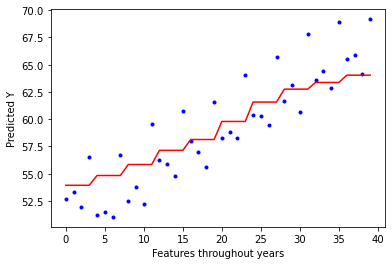

{'r2_score': [-0.5960447296565328], 'explained_variance_score': [0.08320233368741825], 'mean_absolute_error': [2.238303767287567], 'root_mean_squared_error': [3.1992443703929663]}


In [107]:

# import ridge regression from sklearn library
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
# import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error # evaluation metric
from sklearn.metrics import explained_variance_score # evaluation metric
from sklearn.metrics import r2_score as r2 # evaluation metric
from sklearn.metrics import mean_absolute_error # evaluation metric



scaler = StandardScaler()
test_length = 8 # number of years to predict (2 years)
result_dict = {'r2_score' : [], 'explained_variance_score' : [], 'mean_absolute_error' : [], 'root_mean_squared_error' : []}


model = Lasso()


# Extract the data from the dataframe
X = data[3, :, 2:]
Y = data[3, :, 1]


# Split the data into training and test sets
x_train = pd.DataFrame(X[:-test_length])
y_train = Y[:-test_length]
x_test = pd.DataFrame(X[-test_length:])
y_test = Y[-test_length:]
# x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.25, random_state=4)


# Scaled
X_train = pd.DataFrame(scaler.fit_transform(x_train), columns= x_train.columns)
X_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

# # Unscaled
# X_train = x_train
# X_test = x_test


# Fit Model
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)


# calculate errors
result_dict['explained_variance_score'].append(explained_variance_score(y_test, y_pred))
result_dict['mean_absolute_error'].append(mean_absolute_error(y_test, y_pred))
result_dict['root_mean_squared_error'].append(mean_squared_error(y_test, y_pred, squared=False))
result_dict['r2_score'].append(r2(y_test, y_pred))


# Create KFold object with 5 splits
folds = KFold(n_splits = 5, shuffle = False)
scores = cross_val_score(model, X_test, y_test, cv=folds)
print('scores', scores)

# get ridge coefficients and print them
model_coefficient = pd.DataFrame()
model_coefficient["Columns"]= X_train.columns
model_coefficient['Coefficient Estimate'] = pd.Series(model.coef_)

print("r2 score: ", model.score(X_test, y_test))


values = [0,1,2,3,4]
# plt.plot(x_w, test_loss)
# plt.plot(values, scores)
# plt.scatter(X_test, y_pred)
# plt.plot(X_test[1], y_pred)
# plt.scatter(X_test[1], y_pred)
# plt.show()
x_ax = range(len(x_test[5]))
# plt.plot(x_ax, y_test, '.', color= 'blue')
# plt.plot(x_ax, y_pred, 'r')
x_ax_train= range(len(X_train[5])) 
# a= GDP_df.columns
# a = a[132:168]
plt.plot(x_ax_train, y_train, '.', color= 'blue')
plt.plot(x_ax_train, y_pred_train, 'r')
plt.xlabel('Features throughout years')
plt.ylabel('Predicted Y')
plt.savefig('linear_regression_austria.png', format='png')
plt.show()


# calculate errors
# result_dict['explained_variance_score'].append(explained_variance_score(y_train, y_pred_train))
# result_dict['mean_absolute_error'].append(mean_absolute_error(y_train, y_pred_train))
# result_dict['root_mean_squared_error'].append(mean_squared_error(y_train, y_pred_train, squared=False))
# result_dict['r2_score'].append(r2(y_train, y_pred_train))

print(result_dict)

In [104]:
model_coefficient

,Columns,Coefficient Estimate
0,0,-1.853258
1,1,1.853258
2,2,0.417441
3,3,0.393428
4,4,1.030881
5,5,0.864793
6,6,0.330113


In [145]:
test_result_dict = {'r2_score' : [], 'explained_variance_score' : [], 'mean_absolute_error' : [], 'root_mean_squared_error' : []}
train_result_dict = {'r2_score' : [], 'explained_variance_score' : [], 'mean_absolute_error' : [], 'root_mean_squared_error' : []}
scaler = StandardScaler()
test_length = 8 # number of years to predict (2 years)

i = 3

# looping through the countries
# for i in range(15):

model = LinearRegression()

X = data[i, :, 2:]
Y = data[i, :, 1]
# X_norm = preprocessing.normalize(X)

x_train = pd.DataFrame(X[:-test_length])
y_train = Y[:-test_length]
x_test = pd.DataFrame(X[-test_length:])
y_test = Y[-test_length:]
    
# Scaled
# X_train = pd.DataFrame(scaler.fit_transform(x_train), columns= x_train.columns)
# X_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

# # Unscaled
X_train = x_train
X_test = x_test


# Train the model: just change RidgeR= Lasso(alpha=1) for Lasso regression, RidgeR = Ridge(alpha=1) for ridge 
# and RidgeR = LinearRegression() for linear regression
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)


# add to dictionary
test_result_dict['explained_variance_score'].append(explained_variance_score(y_test, y_pred))
test_result_dict['mean_absolute_error'].append(mean_absolute_error(y_test, y_pred))
test_result_dict['root_mean_squared_error'].append(mean_squared_error(y_test, y_pred, squared=False))
test_result_dict['r2_score'].append(r2(y_test, y_pred))

train_result_dict['explained_variance_score'].append(explained_variance_score(y_train, y_pred_train))
train_result_dict['mean_absolute_error'].append(mean_absolute_error(y_train, y_pred_train))
train_result_dict['root_mean_squared_error'].append(mean_squared_error(y_train, y_pred_train, squared=False))
train_result_dict['r2_score'].append(r2(y_train, y_pred_train))

df = pd.DataFrame(data=test_result_dict)
print(df.describe().transpose()['mean'])
df

r2_score                   -3.685559e+24
explained_variance_score   -1.842780e+24
mean_absolute_error         3.437649e+12
root_mean_squared_error     4.861570e+12
Name: mean, dtype: float64


,r2_score,explained_variance_score,mean_absolute_error,root_mean_squared_error
0,-3.685559e+24,-1.842780e+24,3.437649e+12,4.861570e+12


In [137]:
X_test

,0,1,2,3,4,5,6
0,20.0,80.0,43.6,36.4,0.734516,8.333333,5.772166
1,20.0,80.0,43.6,36.4,0.978841,7.300000,5.772166
2,20.0,80.0,43.6,36.4,1.295832,7.266667,5.772166
3,20.0,80.0,43.6,36.4,1.324090,6.733333,5.772166
4,19.2,80.8,43.4,37.3,1.156145,6.700000,5.793236
5,19.2,80.8,43.4,37.3,1.217403,6.700000,5.793236
6,19.2,80.8,43.4,37.3,0.947235,6.766667,5.793236
7,19.2,80.8,43.4,37.3,0.778235,6.800000,5.793236


In [118]:
y_pred

array([ 6.62550483e+01,  6.60050483e+01,  6.61300483e+01,  6.60050483e+01,
       -9.79951631e+12, -9.79951631e+12, -9.79951631e+12, -9.79951631e+12])

ValueError: x and y must have same first dimension, but have shapes (48,) and (36,)

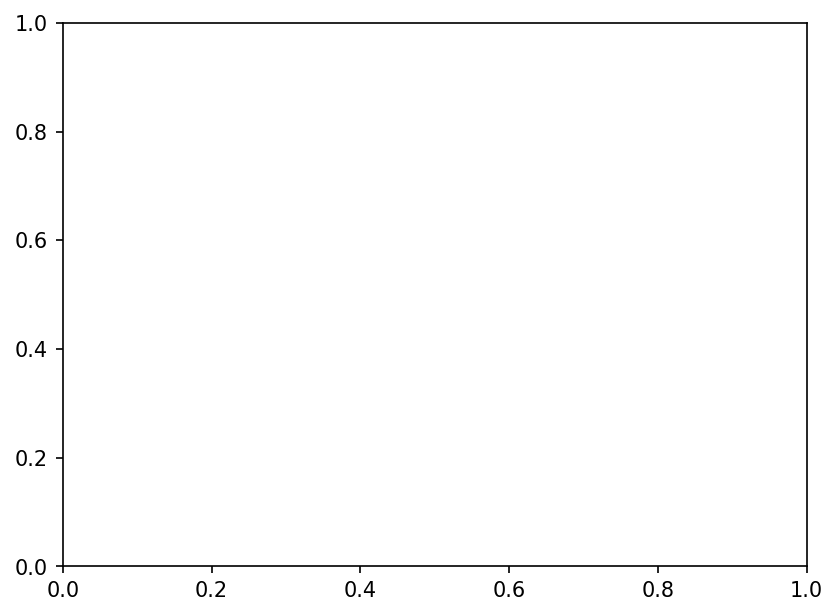

In [78]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error # evaluation metric
from sklearn.metrics import explained_variance_score # evaluation metric
from sklearn.metrics import r2_score as r2 # evaluation metric
from sklearn.metrics import mean_absolute_error # evaluation metric

plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.rcParams["figure.dpi"] = 150.

i = 0

# looping through the countries
# for i in range(15):
test_length = 8
# model = LinearRegression()

X = data[i, :, 2:]
Y = data[i, :, 1]

x_train = pd.DataFrame(X)
y_train = Y
x_test = pd.DataFrame(X[-test_length:])
y_test = Y[-test_length:]

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.25, random_state=4)
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)
X_train = pd.DataFrame(scaler.fit_transform(x_train), columns= x_train.columns)
X_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

# X_train = x_train
# X_test = x_test

model = RandomForestRegressor()
model.fit(X_train, y_train)
predictions = model.predict(X_train)
 

time = 48
times = []
for i in range(48):
    times.append(2008.25+i/4)

plt.plot(times, Y[:time], color= 'blue')
plt.plot(times, predictions[:time], linestyle='dashed', color='r')
plt.xlabel('Year')
plt.ylabel('GDP per Hour Worked')
plt.legend(['Actual', 'Regression'])
plt.show()


# print(r2(y_train, predictions))

In [82]:
# predictions
predictions.shape

(36,)

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

fhjdk = KFold(n_splits = 3, shuffle = True, random_state = 4)
print(cross_val_score(LinearRegression(), X_train, y_train, cv=fhjdk))
print(cross_val_score(Lasso(), X_train, y_train, cv=fhjdk))
print(cross_val_score(Ridge(), X_train, y_train, cv=fhjdk))
print(cross_val_score(ElasticNet(), X_train, y_train, cv=fhjdk))
print(cross_val_score(RandomForestRegressor(), X_train, y_train, cv=fhjdk))

[0.81594434 0.78879855 0.87845232]
[0.79048554 0.79937109 0.84646539]
[0.85307597 0.81059579 0.8366232 ]
[0.78870473 0.78044738 0.7719918 ]
[0.84171778 0.74493704 0.7649774 ]


In [50]:
2008+(48/4)

2020.0